Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.

Training EfficientNetB3 Model...


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.4039 - loss: 1.2025 - val_accuracy: 0.6990 - val_loss: 0.7527
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5556 - loss: 0.8557 - val_accuracy: 0.7864 - val_loss: 0.6247
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7384 - loss: 0.6354 - val_accuracy: 0.7767 - val_loss: 0.5836
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.7328 - loss: 0.6270 - val_accuracy: 0.7961 - val_loss: 0.5547
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7686 - loss: 0.6011 - val_accuracy: 0.8350 - val_loss: 0.5231
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7200 - loss: 0.5661 - val_accuracy: 0.7282 - val_loss: 0.7058
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8037 - loss: 0.4843 - val_accuracy: 0.7767 - val_loss: 0.6323
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8294 - loss: 0.4540 - val_accuracy: 0.7476 - val_loss:

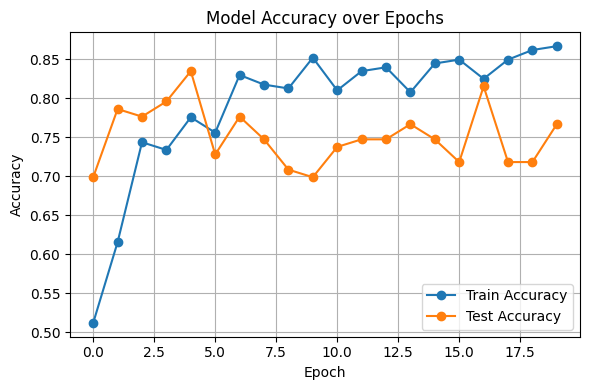

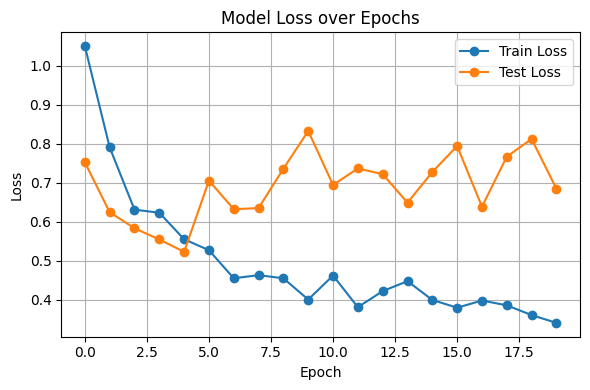

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# ---- Paths ----
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'

# ---- Hyperparameters ----
batch_size = 32
dropout_rate = 0.3
learning_rate = 0.001
target_size = (224, 224)  
num_classes = 3  

# ---- Data Preprocessing ----
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed   
)

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = datagen.flow_from_directory(
    val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_generator = datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

def build_model(base_model):
    base_model.trainable = False  # Freeze base layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base_model.input, outputs=output)

# ---- EfficientNetB0 Model ----
efficientnet_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = build_model(efficientnet_base)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining EfficientNetB3 Model...")
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    batch_size=batch_size,
    verbose=1
)

# ---- Evaluate EfficientNetB3 ----
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"EfficientNetB0 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"EfficientNetB0 Test Loss: {test_loss:.4f}")

# Evaluate for training
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the final model
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

import numpy as np
import pickle
# ---- Save the training history as a pickle file (.pkl) ----
history_file = 'efficientnetb3_cv(new).pkl'

with open(history_file, 'wb') as f:
    pickle.dump(history.history, f)

print("Model training complete and history")

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
🔍 Validation Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.68      0.58      0.62       500
               Nor       0.81      0.99      0.89       500
Squamous_carcinoma       0.76      0.70      0.72       500

          accuracy                           0.75      1500
         macro avg       0.75      0.75      0.75      1500
      weighted avg       0.75      0.75      0.75      1500

🔍 Test Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.74      0.90      0.81        39
               Nor       0.72      0.84      0.78        31
Squamous_carcinoma       0.90      0.55      0.68        33

          accuracy                           0.77       103
         macro avg       0.79      0.76      0.76       103
      weighted avg       0.79      0.77      0.76       103

Validation Accuracy: 0.75466666

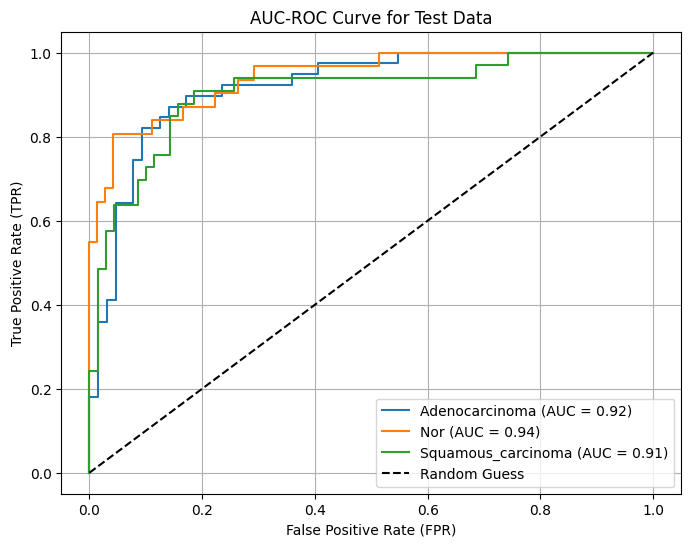


Macro-Averaged Test AUC: 0.92
47/47 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.82
Nor - AUC: 0.98
Squamous_carcinoma - AUC: 0.89


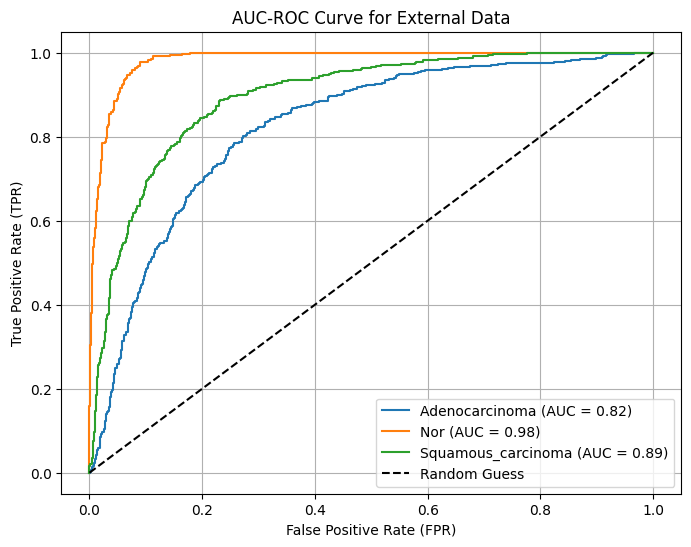


Macro-Averaged Test AUC: 0.90


In [4]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Predicting on validation data
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes

# Predicting on test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("🔍 Validation Data Metrics:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_generator.class_indices.keys()))

print("🔍 Test Data Metrics:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices.keys()))

# Additional individual metrics for better control
print("Validation Accuracy:", accuracy_score(val_true_labels, val_pred_labels))
print("Validation Precision:", precision_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation F1-Score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Test Precision:", precision_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test Recall:", recall_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test F1-Score:", f1_score(test_true_labels, test_pred_labels, average='weighted'))

# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for External Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")